<a href="https://colab.research.google.com/github/wikimacd/searchfromgeneontology/blob/main/LSTMWprd2vecGermline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
df = pd.read_excel(r'/content/drive/MyDrive/Z_Macdonald.xlsx')
df['total']=df['title']+' '+df['abstract_text']

In [116]:
df = df[df['abstract_text'].notna()]
df = df[df['Germline'].notna()]
df = df[df['Somatic'].notna()]

In [117]:
df['Somatic'] = df['Somatic'].astype(int)
df['Germline'] = df['Germline'].astype(int)
df = df[["total", "Somatic", "Germline"]]
#df = df[["abstract_text", "Somatic", "Germline"]]
df.head()

,total,Somatic,Germline
0,Hereditary Diffuse Gastric Cancer Syndrome: CD...,0,1
1,"Cancer mortality among Chinese, Japanese, and ...",0,0
2,Relative risk of stump cancer following partia...,0,0
3,[Endoscopic diagnosis of carcinoma in the oper...,0,0
4,Hereditary Cancer Syndromes-A Primer on Diagno...,0,1


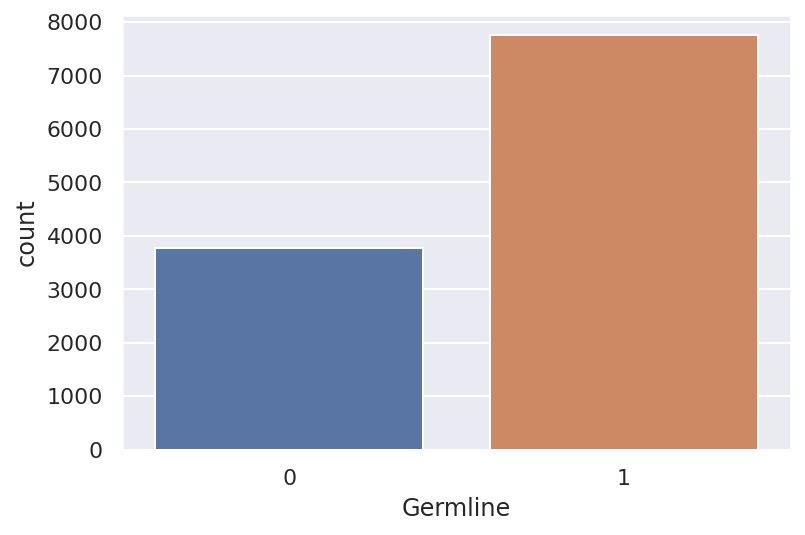

In [118]:
sns.set()
sns.countplot(df.Germline)
#sns.countplot(df.Somatic)
plt.show()

In [119]:
df['word_length'] = df['total'].apply(lambda x:len(x.split()))
df.tail()

,total,Somatic,Germline,word_length
11601,Analysis of the candidate target genes for mut...,1,1,186
11602,Extended structural variation of a pentanucleo...,0,0,205
11603,"Allelic loss of 14q and 22q, NF2 mutation, and...",0,1,246
11604,Gastric cancer and human leukocyte antigen: di...,0,1,191
11605,Single nucleotide polymorphisms in intron 2 of...,0,0,215


In [120]:
df['word_length'].describe()

count    11530.000000
mean       244.162706
std         70.659094
min         15.000000
25%        205.000000
50%        247.000000
75%        277.000000
max       2226.000000
Name: word_length, dtype: float64

In [121]:
pip install text-hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [122]:
import text_hammer as th

In [123]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
#     df[column] = df[column].progress_apply(lambda x:th.spelling_correction(x))
  
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 874 µs, sys: 0 ns, total: 874 µs
Wall time: 884 µs


In [ ]:
cleaned_df = text_preprocessing(df, "total")

  0%|          | 0/11530 [00:00<?, ?it/s]

  0%|          | 0/11530 [00:00<?, ?it/s]

  0%|          | 0/11530 [00:00<?, ?it/s]

  0%|          | 0/11530 [00:00<?, ?it/s]

  0%|          | 0/11530 [00:00<?, ?it/s]

In [ ]:
cleaned_df.total

0        abstract_x000d _ importance ecadherin cdh1 can...
1        compare ageadjuste mortality rate cancer selec...
2        relative risk stump cancer follow partial gast...
3        24 000 gastroscopy 4 medical department 705 su...
4        hereditary cause mutation defect certain gene ...
                               ...                        
11601    microsatellite instability msi human carcinoma...
11602    promoter region human gstp1 gene contain polym...
11603    gastrointestinal stromal tumor gist common mes...
11604    dna sera 130 case gastric cancer 263 populatio...
11605    previous study suggest variable number tandem ...
Name: abstract_text, Length: 11530, dtype: object

In [ ]:
import nltk
nltk.download('punkt')
## Calculating the word frequency by using nltk
words_list = []
for sentence in cleaned_df.abstract_text:
    words_list.extend(nltk.word_tokenize(sentence))
freq_dist = nltk.FreqDist(words_list)
freq_dist.most_common(20)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('cancer', 50783),
 ('mutation', 31909),
 ('patient', 24279),
 ('risk', 18330),
 ('gene', 18317),
 ('breast', 15441),
 ('study', 13164),
 ('tumor', 10768),
 ('family', 9907),
 ('case', 8980),
 ('95', 8465),
 ('identify', 7525),
 ('genetic', 7225),
 ('ci', 7189),
 ('increase', 7138),
 ('gastric', 7097),
 ('brca1', 6907),
 ('p', 6876),
 ('high', 6644),
 ('analysis', 6613)]

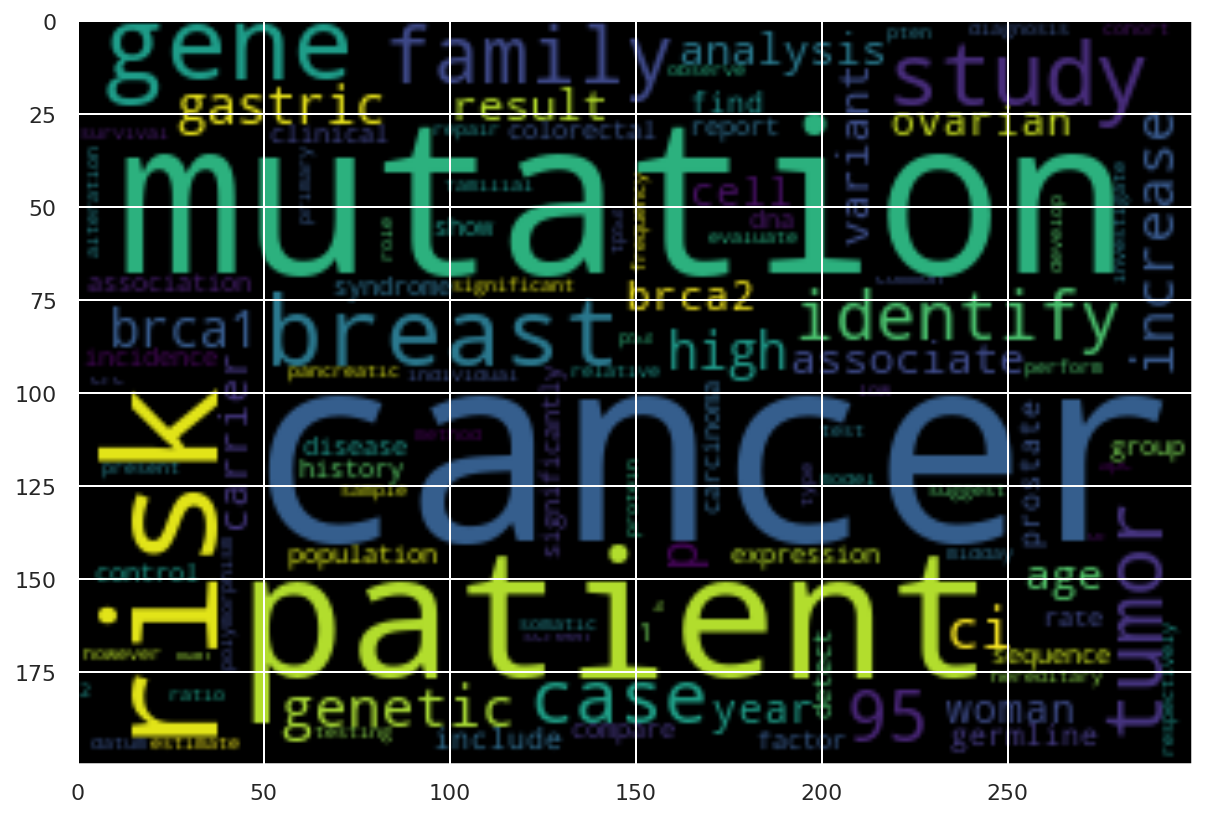

In [ ]:
### Creating wordcloud
from wordcloud import WordCloud
import wordcloud
# creation of wordcloud
wcloud_fig = WordCloud( stopwords=set(wordcloud.STOPWORDS),
                      colormap='viridis', width=300, height=200).generate_from_frequencies(freq_dist)

# plotting the wordcloud
plt.figure(figsize=(10,7), frameon=True)

plt.imshow(wcloud_fig, interpolation  = 'bilinear')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(cleaned_df.abstract_text, cleaned_df.Germline, test_size = 0.2, stratify = cleaned_df.Germline
                                                 ,random_state = 42)

In [ ]:
from keras.preprocessing.text import Tokenizer
num_words = 100000 # this means 15000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
df_total = pd.concat([X_train, X_test], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
len(tokenizer.word_index) # this is whole unique words in our corpus
# but we have taken 100000 but we have only 64377 and the rest will be zero

63370

In [ ]:
cleaned_df.word_length.max()

2212

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=2212,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 2212, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape) # this is our 2D matrix we can take this as Input data

(9224, 2212) (2306, 2212)


In [ ]:
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator#
from tqdm import tqdm
import math
#from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten
#from keras.optimizers import Adam
from keras.models import Model
#from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
#from nltk.corpus import stopwords
#from keras.utils import to_categorical
import os

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow import keras
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

In [ ]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1] # max_len of text sequence
                          ))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
history_embedding = model.fit(X_train_pad,y_train, epochs = 15, batch_size = 120, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

Epoch 1/15
77/77 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.8191
Epoch 1: val_accuracy improved from -inf to 0.87337, saving model to ./model.h5
77/77 [==============================] - 119s 1s/step - loss: 0.4276 - accuracy: 0.8191 - val_loss: 0.3271 - val_accuracy: 0.8734
Epoch 2/15
77/77 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9170
Epoch 2: val_accuracy improved from 0.87337 to 0.87771, saving model to ./model.h5
77/77 [==============================] - 108s 1s/step - loss: 0.2234 - accuracy: 0.9170 - val_loss: 0.3148 - val_accuracy: 0.8777
Epoch 3/15
77/77 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9655
Epoch 3: val_accuracy did not improve from 0.87771
77/77 [==============================] - 109s 1s/step - loss: 0.1137 - accuracy: 0.9655 - val_loss: 0.4678 - val_accuracy: 0.8491
Epoch 4/15
77/77 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9832
Epoch 4: val_accurac

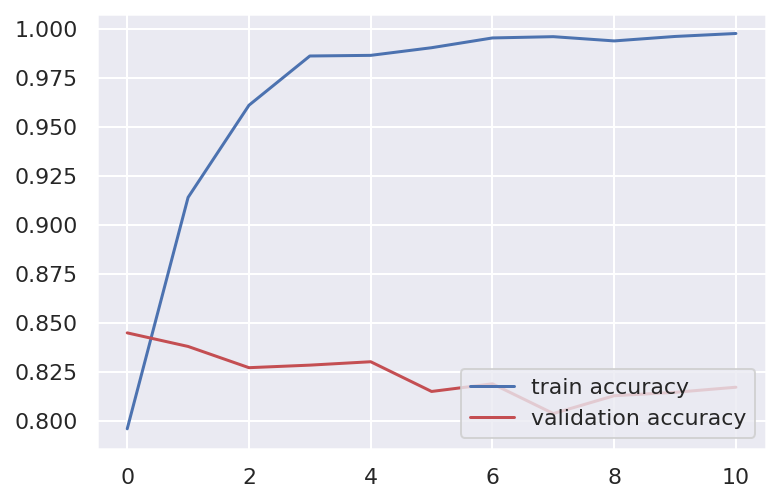

In [ ]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test_pad, y_test)

73/73 [==============================] - 21s 261ms/step - loss: 1.0970 - accuracy: 0.8170


[1.0970460176467896, 0.8169991374015808]

In [ ]:
import gensim.downloader as api
glove_gensim  = api.load('glove-wiki-gigaword-100') # this would download vector with 100 dimension

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
glove_gensim['cat'].shape[0] # this is the diemnsion of the vectors

100

In [ ]:
# now lets connvert all the words we have in our data into vectors 
vector_size = 100
gensim_weight_matrix = np.zeros((num_words ,vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words: # since index starts with zero 
        if word in glove_gensim.wv.vocab:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(100)

In [ ]:
gensim_weight_matrix.shape

(100000, 100)

In [ ]:
EMBEDDING_DIM = 100 # this means the embedding layer will create  a vector in 100 dimension
model_gensim = Sequential()
model_gensim.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
model_gensim.add(Dropout(0.2))
model_gensim.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
model_gensim.add(Dense(1, activation = 'sigmoid'))
model_gensim.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = 'accuracy')

In [ ]:
model_gensim.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2226, 100)         10000000  
                                                                 
 dropout_3 (Dropout)         (None, 2226, 100)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 2226, 200)        161600    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 2226, 200)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 2226, 400)        643200    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 2226, 400)        

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model_gensim.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)



In [ ]:
history_gensim = model_gensim.fit(X_train_pad,y_train, epochs = 10, batch_size = 120, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc]  )

Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7686
Epoch 1: val_accuracy improved from -inf to 0.82264, saving model to ./model_gensim.h5
77/77 [==============================] - 111s 1s/step - loss: 0.4921 - accuracy: 0.7686 - val_loss: 0.4161 - val_accuracy: 0.8226
Epoch 2/10
77/77 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.8298
Epoch 2: val_accuracy improved from 0.82264 to 0.84345, saving model to ./model_gensim.h5
77/77 [==============================] - 109s 1s/step - loss: 0.4080 - accuracy: 0.8298 - val_loss: 0.3895 - val_accuracy: 0.8435
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8429
Epoch 3: val_accuracy improved from 0.84345 to 0.84605, saving model to ./model_gensim.h5
77/77 [==============================] - 111s 1s/step - loss: 0.3899 - accuracy: 0.8429 - val_loss: 0.3863 - val_accuracy: 0.8461
Epoch 4/10
77/77 [==============================] - ETA: 0s -

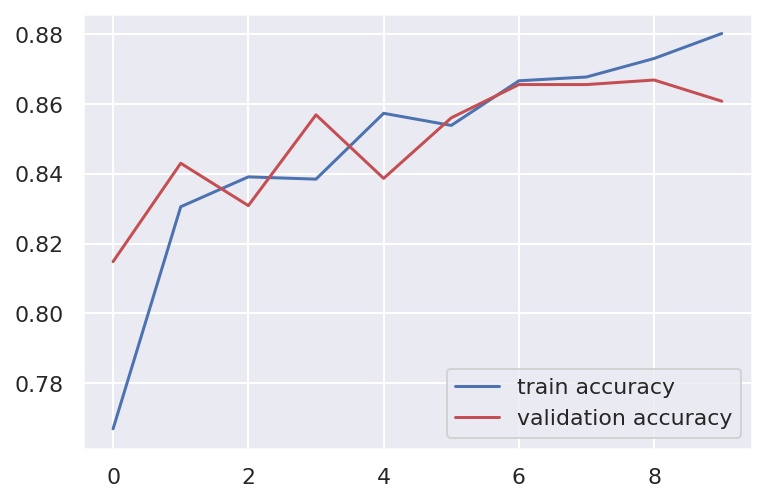

In [ ]:
# lets draw learning curve 

plt.plot(history_gensim.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_gensim.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_gensim.evaluate(X_test_pad, y_test)

73/73 [==============================] - 15s 207ms/step - loss: 0.3532 - accuracy: 0.8608


[0.3531997501850128, 0.8607979416847229]

In [ ]:
model.evaluate(X_test_pad, y_test)

73/73 [==============================] - 15s 203ms/step - loss: 0.7410 - accuracy: 0.8552


[0.7410250902175903, 0.8551604747772217]

In [ ]:
y_pred = np.where(model.predict(X_test_pad)>.5,1,0)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1758
           1       0.65      0.78      0.71       548

    accuracy                           0.85      2306
   macro avg       0.79      0.82      0.80      2306
weighted avg       0.86      0.85      0.85      2306



In [ ]:
y_pred_gensim = np.where(model_gensim.predict(X_test_pad)>0.5,1,0)
print(metrics.classification_report(y_pred_gensim, y_test))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1822
           1       0.62      0.85      0.72       484

    accuracy                           0.86      2306
   macro avg       0.79      0.86      0.81      2306
weighted avg       0.89      0.86      0.87      2306

